In [3]:
# Import project dependencies

import pandas as pd
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import  word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score,precision_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K
from keras.layers import MaxPool1D
from keras.models import Model

# glove vectorizer dependencies
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import io
import os

In [4]:
# Read csv dataset and save to df

filePath = 'TOTAL_TEXTS_SETOPATI.csv'
VALIDATION_SPLIT = 0.3
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

df = pd.read_csv(filePath)
# computing number of rows
rows = len(df.axes[0])
 
# computing number of columns
cols = len(df.axes[1])
print("DataFrame Size: "+ str(df.size))
print("Row Size: "+ str(rows))
print("Column Size: "+ str(cols))

DataFrame Size: 520235
Row Size: 104047
Column Size: 5


In [5]:
#Preprocessing {Remove Stop words using nltk}

stop_words = stopwords.words("nepali")
def string_manipulation(df,column)  : 
    df[column] = df[column].apply(lambda x: re.sub('[।(),०-९<<?!,—,–,/,’,‘,:,\u200d]', '', x))
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split()if i not in (stop_words)]))
    return df
Data = string_manipulation(df,"text")

In [6]:
# convert word into vector

print('Indexing word vectors.')
embeddings_dict = {}

# Used NPVec1: Word Embeddings for Nepali for glove from [https://github.com/nowalab/nepali-word-embeddings]
# processed.glove.txt, processed_normalized_stemmed.glove 

with open("processed.glove", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

print('Found %s word vectors.' % len(embeddings_dict))

Indexing word vectors.
Found 663564 word vectors.


In [7]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
# second, prepare text samples and their labels

newsTexts = Data['text'].tolist()
labels_index = {}  # dictionary mapping label name to numeric id
labels = [] # list of label ids
allCategoryDataList = Data['catagory']

indexCount = 0
for category in allCategoryDataList.unique():
    labels_index[category] = indexCount
    indexCount = indexCount + 1

for category in allCategoryDataList.tolist():
    labels.append(labels_index[category])
        
# print('Found %s news texts.' % len(newsTexts))
# print('Found %s news labels.' % labels)
# print('Categories with label ids:\n %s' % labels_index)
display(df.loc[0:4])



,catagory,heading,text,date,link
0,new-news,मेसीलाई तुरुन्त अनुबन्धित गर्न बार्सिलोनालाई न...,ब्राजिलका स्टार स्ट्राइकर नेइमारले अर्जेन्टिनी...,"बुधबार, वैशाख २७, २०७४, ००:४२:२९",https://dev.setoparty.com/new-news/45151
1,archive-news,नेपाल र नामिबियाबीचको खेलमा यस्तो छ सुरक्षा,\n\tकाठमाडौंको कीर्तिपुर क्रिकेट मैदानमा भोलि ...,2016-04-15 16:41:04,https://dev.setoparty.com/archive-news/45151
2,politics,अलबिदा मणी शाह (भिडियो र फोटोफिचर),नेपाली राष्ट्रिय फुटबल टोलीका खेलाडी मणी विक्र...,"मंगलबार, जेठ १, २०७५, ०३:०५:४२",https://dev.setoparty.com/politics/158282
3,politics,मलेसियालाई १० विकेटले हराउँदै नेपाल एसिया कपमा...,मलेसियालाई विकेटको फराकिलो अन्तरमा हराउँदै नेप...,"शनिबार, भदौ ३१, २०७४, ०३:२२:४७",https://dev.setoparty.com/politics/87233
4,sports,अर्धसतक पूरा गर्दै अाउट भए ज्ञानेन्द्र,\xa0विश्व क्रिकेट लिग डब्लुसिएल च्याम्पियनसिप ...,"बुधबार, मंसिर २०, २०७४, ०२:११:१६",https://dev.setoparty.com/sports/111454


In [9]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(newsTexts)
sequences = tokenizer.texts_to_sequences(newsTexts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labelsCategorical = to_categorical(np.asarray(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labelsCategorical.shape)
print('label tensor:', labelsCategorical[0])

# split the data into a training set(70%) and a validation set(30%)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
finalLabels = labelsCategorical[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = finalLabels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = finalLabels[-num_validation_samples:]

Found 899236 unique tokens.
Shape of data tensor: (104047, 1000)
Shape of label tensor: (104047, 63)
label tensor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
# # load json and create model
# # from keras.models import model_from_json 
# from tensorflow.keras.models import Sequential, model_from_json
# from keras_self_attention import SeqSelfAttention


# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json, custom_objects={'SeqSelfAttention': SeqSelfAttention})
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# # loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# loaded_model.compile(optimizer='adam', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

# score = loaded_model.evaluate(x_val, y_val, verbose=0)
# index = 0
# for metric in loaded_model.metrics_names:
#     print("%s: %.2f%%" % (metric, score[index]*100))
#     index = index + 1

In [11]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
done


In [12]:
# print('Training model. CNN CNN Model.')

# # train a 1D convnet with global maxpooling
# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)

# x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# x1 = Dropout(0.2)(x)
# x2 = MaxPooling1D(5)(x1)
# x3 = Conv1D(128, 5, activation='relu')(x2)
# x4 = Dropout(0.3)(x3)
# x5 = MaxPooling1D(5)(x4)
# x6 = Conv1D(128, 5, activation='relu')(x5)
# x7 = GlobalMaxPooling1D()(x6)
# x8 = Dense(128, activation='relu')(x7)
# print("len labels:", str(len(labels_index)))
# preds = Dense(len(labels_index), activation='softmax')(x8)

# print("Preds shape: ", preds.shape)
# print("sequence_input shape: ", sequence_input.shape)

# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc', f1_m, precision_m, recall_m])

# print("Shape of x_train: ", x_train.shape)
# print("Shape of y_train: ", y_train.shape)
# print("Shape of x_val: ", x_val.shape)
# print("Shape of y_val: ", y_val.shape)
# print(model.output_shape)
# model.summary()


# history = model.fit(x_train, y_train,
#           batch_size=128,
#           epochs=15,
#           validation_data=(x_val, y_val))

In [13]:
# print('Training model. CNN biLstm Model.')
# from keras.models import Sequential
# from keras.layers import Embedding
# from tensorflow.keras.layers import Bidirectional
# from keras.layers import LSTM
# from keras.layers import Activation
# from keras.layers import Flatten


# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)

# model = Sequential()
# model.add(embedding_layer)
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(5))
# model.add(Dropout(0.2)) # embedding dropouts
# model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, activation = 'tanh'))) # weight drop on recurrent layers using recurrent_dropout
# # model.add(GlobalMaxPooling1D())
# # model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(63, activation="softmax"))

# model.summary()
# # model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam', metrics = ['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])


# train the model
# model.fit(x_train, y_train, X_val=x_val, y_val=y_val,
#     epoch_num=15, optimizer='adam', verbose=True)
# history = model.fit(x_train, y_train,
#           batch_size=128,
#           epochs=15,
#           validation_data=(x_val, y_val))

In [14]:
# CNN Bilstm attention
from keras.layers import Input, Dense, LSTM, concatenate,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
from keras_self_attention import SeqSelfAttention

from tensorflow.keras.layers import Attention
from keras.layers.core import *
from keras.models import *

lstm_units = 64
SINGLE_ATTENTION_VECTOR = False

def hybrid_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(embedded_sequences)  #, padding = 'same'
    x = MaxPooling1D(5)(x)
    x = Dropout(0.2)(x)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(x)
    lstm_out = Dropout(0.2)(lstm_out)
    attention_mul = SeqSelfAttention(attention_width=15, attention_activation='relu',name='Attention')(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(63, activation='softmax')(attention_mul)
    model = Model(inputs=[sequence_input], outputs=output)
    return model

def attention_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    attention_mul = SeqSelfAttention(attention_width=15, attention_activation='relu',name='Attention')(embedded_sequences)
    attention_mul = Dropout(0.2)(attention_mul)
    attention_mul = Flatten()(attention_mul)
    output = Dense(63, activation='sigmoid')(attention_mul)
    model = Model(inputs=[sequence_input], outputs=output)
    return model


def bilstm_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences)
    x1 = Dropout(0.2)(lstm_out)
    output = Dense(63, activation='sigmoid')(x1)
    model = Model(inputs=[sequence_input], outputs=output)
    return model

def cnn_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(embedded_sequences) 
    x1 = MaxPooling1D(5)(x)
    x2 = Dropout(0.2)(x1)
    x3 = Flatten()(x2)
    output = Dense(63, activation='sigmoid')(x3)
    model = Model(inputs=[sequence_input], outputs=output)
    return model

m = hybrid_model()
m.summary()
m.compile(optimizer='adam', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 300)         6000000   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 199, 256)         263168    
 l)                                                          

In [15]:
history = m.fit([x_train], y_train, epochs=200, batch_size=64, validation_split=0.3, validation_data=(x_val, y_val))

Epoch 1/200


2023-01-20 03:14:05.806231: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1139/1139 [==============================] - 899s 787ms/step - loss: 0.0075 - acc: 0.6732 - f1_m: 0.6674 - precision_m: 0.7890 - recall_m: 0.5827 - val_loss: 0.0067 - val_acc: 0.7124 - val_f1_m: 0.7139 - val_precision_m: 0.7995 - val_recall_m: 0.6460
Epoch 2/200
1139/1139 [==============================] - 910s 799ms/step - loss: 0.0062 - acc: 0.7328 - f1_m: 0.7304 - precision_m: 0.8208 - recall_m: 0.6595 - val_loss: 0.0064 - val_acc: 0.7284 - val_f1_m: 0.7296 - val_precision_m: 0.7941 - val_recall_m: 0.6757
Epoch 3/200
1139/1139 [==============================] - 897s 788ms/step - loss: 0.0057 - acc: 0.7582 - f1_m: 0.7564 - precision_m: 0.8352 - recall_m: 0.6924 - val_loss: 0.0063 - val_acc: 0.7335 - val_f1_m: 0.7301 - val_precision_m: 0.8098 - val_recall_m: 0.6658
Epoch 4/200
1139/1139 [==============================] - 894s 785ms/step - loss: 0.0054 - acc: 0.7722 - f1_m: 0.7728 - precision_m: 0.8445 - recall_m: 0.7136 - val_loss: 0.0060 - val_acc: 0.7489 - val_f1_m: 0.7501 - val_pre

1139/1139 [==============================] - 910s 799ms/step - loss: 0.0018 - acc: 0.9325 - f1_m: 0.9336 - precision_m: 0.9409 - recall_m: 0.9265 - val_loss: 0.0070 - val_acc: 0.7393 - val_f1_m: 0.7423 - val_precision_m: 0.7554 - val_recall_m: 0.7300
Epoch 33/200
1139/1139 [==============================] - 909s 798ms/step - loss: 0.0018 - acc: 0.9308 - f1_m: 0.9325 - precision_m: 0.9391 - recall_m: 0.9262 - val_loss: 0.0069 - val_acc: 0.7414 - val_f1_m: 0.7448 - val_precision_m: 0.7579 - val_recall_m: 0.7324
Epoch 34/200
1139/1139 [==============================] - 896s 786ms/step - loss: 0.0017 - acc: 0.9350 - f1_m: 0.9369 - precision_m: 0.9433 - recall_m: 0.9307 - val_loss: 0.0070 - val_acc: 0.7407 - val_f1_m: 0.7438 - val_precision_m: 0.7543 - val_recall_m: 0.7337
Epoch 35/200
1139/1139 [==============================] - 885s 777ms/step - loss: 0.0017 - acc: 0.9359 - f1_m: 0.9373 - precision_m: 0.9434 - recall_m: 0.9314 - val_loss: 0.0070 - val_acc: 0.7362 - val_f1_m: 0.7398 - val_

1139/1139 [==============================] - 884s 777ms/step - loss: 0.0014 - acc: 0.9476 - f1_m: 0.9478 - precision_m: 0.9510 - recall_m: 0.9447 - val_loss: 0.0073 - val_acc: 0.7392 - val_f1_m: 0.7417 - val_precision_m: 0.7487 - val_recall_m: 0.7349
Epoch 64/200
1139/1139 [==============================] - 867s 762ms/step - loss: 0.0015 - acc: 0.9426 - f1_m: 0.9436 - precision_m: 0.9469 - recall_m: 0.9403 - val_loss: 0.0072 - val_acc: 0.7416 - val_f1_m: 0.7437 - val_precision_m: 0.7509 - val_recall_m: 0.7368
Epoch 65/200
1139/1139 [==============================] - 881s 773ms/step - loss: 0.0014 - acc: 0.9495 - f1_m: 0.9504 - precision_m: 0.9533 - recall_m: 0.9476 - val_loss: 0.0073 - val_acc: 0.7377 - val_f1_m: 0.7400 - val_precision_m: 0.7466 - val_recall_m: 0.7336
Epoch 66/200
1139/1139 [==============================] - 890s 782ms/step - loss: 0.0014 - acc: 0.9500 - f1_m: 0.9512 - precision_m: 0.9539 - recall_m: 0.9485 - val_loss: 0.0073 - val_acc: 0.7353 - val_f1_m: 0.7380 - val_

1139/1139 [==============================] - 873s 766ms/step - loss: 0.0013 - acc: 0.9515 - f1_m: 0.9522 - precision_m: 0.9542 - recall_m: 0.9503 - val_loss: 0.0074 - val_acc: 0.7382 - val_f1_m: 0.7401 - val_precision_m: 0.7469 - val_recall_m: 0.7335
Epoch 95/200
1139/1139 [==============================] - 884s 776ms/step - loss: 0.0013 - acc: 0.9519 - f1_m: 0.9527 - precision_m: 0.9548 - recall_m: 0.9507 - val_loss: 0.0074 - val_acc: 0.7392 - val_f1_m: 0.7408 - val_precision_m: 0.7461 - val_recall_m: 0.7356
Epoch 96/200
1139/1139 [==============================] - 888s 780ms/step - loss: 0.0013 - acc: 0.9522 - f1_m: 0.9529 - precision_m: 0.9551 - recall_m: 0.9509 - val_loss: 0.0075 - val_acc: 0.7344 - val_f1_m: 0.7360 - val_precision_m: 0.7422 - val_recall_m: 0.7299
Epoch 97/200
1139/1139 [==============================] - 889s 781ms/step - loss: 0.0013 - acc: 0.9520 - f1_m: 0.9527 - precision_m: 0.9548 - recall_m: 0.9506 - val_loss: 0.0074 - val_acc: 0.7377 - val_f1_m: 0.7394 - val_

Epoch 125/200
1139/1139 [==============================] - 901s 791ms/step - loss: 0.0013 - acc: 0.9542 - f1_m: 0.9549 - precision_m: 0.9564 - recall_m: 0.9533 - val_loss: 0.0076 - val_acc: 0.7348 - val_f1_m: 0.7358 - val_precision_m: 0.7397 - val_recall_m: 0.7320
Epoch 126/200
1139/1139 [==============================] - 947s 831ms/step - loss: 0.0012 - acc: 0.9548 - f1_m: 0.9554 - precision_m: 0.9568 - recall_m: 0.9541 - val_loss: 0.0076 - val_acc: 0.7360 - val_f1_m: 0.7371 - val_precision_m: 0.7405 - val_recall_m: 0.7337
Epoch 127/200
1139/1139 [==============================] - 884s 776ms/step - loss: 0.0013 - acc: 0.9539 - f1_m: 0.9545 - precision_m: 0.9559 - recall_m: 0.9531 - val_loss: 0.0076 - val_acc: 0.7358 - val_f1_m: 0.7372 - val_precision_m: 0.7408 - val_recall_m: 0.7337
Epoch 128/200
1139/1139 [==============================] - 901s 791ms/step - loss: 0.0012 - acc: 0.9549 - f1_m: 0.9552 - precision_m: 0.9569 - recall_m: 0.9536 - val_loss: 0.0076 - val_acc: 0.7338 - val_f1

Epoch 156/200
1139/1139 [==============================] - 885s 777ms/step - loss: 0.0013 - acc: 0.9546 - f1_m: 0.9553 - precision_m: 0.9566 - recall_m: 0.9540 - val_loss: 0.0077 - val_acc: 0.7360 - val_f1_m: 0.7366 - val_precision_m: 0.7395 - val_recall_m: 0.7338
Epoch 157/200
1139/1139 [==============================] - 873s 766ms/step - loss: 0.0012 - acc: 0.9561 - f1_m: 0.9566 - precision_m: 0.9576 - recall_m: 0.9557 - val_loss: 0.0077 - val_acc: 0.7353 - val_f1_m: 0.7368 - val_precision_m: 0.7400 - val_recall_m: 0.7337
Epoch 158/200
1139/1139 [==============================] - 889s 781ms/step - loss: 0.0012 - acc: 0.9554 - f1_m: 0.9557 - precision_m: 0.9569 - recall_m: 0.9546 - val_loss: 0.0077 - val_acc: 0.7363 - val_f1_m: 0.7372 - val_precision_m: 0.7397 - val_recall_m: 0.7347
Epoch 159/200
1139/1139 [==============================] - 894s 785ms/step - loss: 0.0012 - acc: 0.9554 - f1_m: 0.9560 - precision_m: 0.9571 - recall_m: 0.9548 - val_loss: 0.0076 - val_acc: 0.7355 - val_f1

Epoch 187/200
1139/1139 [==============================] - 861s 756ms/step - loss: 0.0012 - acc: 0.9563 - f1_m: 0.9568 - precision_m: 0.9577 - recall_m: 0.9558 - val_loss: 0.0078 - val_acc: 0.7326 - val_f1_m: 0.7337 - val_precision_m: 0.7363 - val_recall_m: 0.7311
Epoch 188/200
1139/1139 [==============================] - 866s 761ms/step - loss: 0.0012 - acc: 0.9556 - f1_m: 0.9561 - precision_m: 0.9570 - recall_m: 0.9552 - val_loss: 0.0078 - val_acc: 0.7330 - val_f1_m: 0.7339 - val_precision_m: 0.7366 - val_recall_m: 0.7313
Epoch 189/200
1139/1139 [==============================] - 875s 768ms/step - loss: 0.0013 - acc: 0.9550 - f1_m: 0.9553 - precision_m: 0.9562 - recall_m: 0.9543 - val_loss: 0.0077 - val_acc: 0.7359 - val_f1_m: 0.7370 - val_precision_m: 0.7399 - val_recall_m: 0.7341
Epoch 190/200
1139/1139 [==============================] - 877s 770ms/step - loss: 0.0013 - acc: 0.9550 - f1_m: 0.9554 - precision_m: 0.9562 - recall_m: 0.9546 - val_loss: 0.0078 - val_acc: 0.7306 - val_f1

In [16]:
# BiLstm CNN Model 
# from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
# from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
# from keras.optimizers import Adam

# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
# x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],trainable = False)(sequence_input)
# x = SpatialDropout1D(0.2)(x)
# x = Bidirectional(LSTM(128, return_sequenc `1es=True,dropout=0.1,recurrent_dropout=0.1))(x)
# x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# x = concatenate([avg_pool, max_pool]) 
# # x = Dense(128, activation='relu')(x)
# # x = Dropout(0.1)(x)
# preds = Dense(63, activation="sigmoid")(x)
# model = Model(sequence_input, preds)
# model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
# model.summary()
# history = model.fit(x_train, y_train, epochs = 20, validation_split=0.1, shuffle=True, batch_size=64)

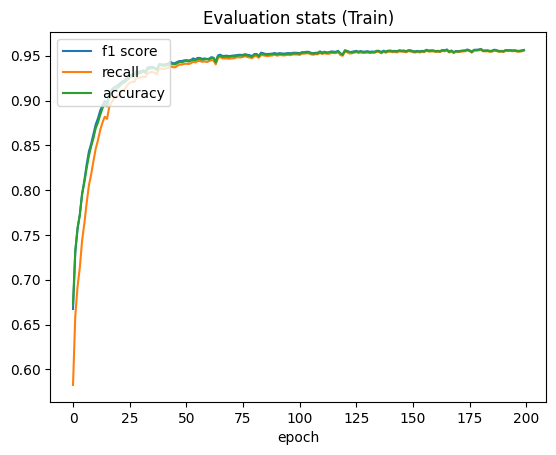

In [17]:
import matplotlib.pyplot as plt
from matplotlib import pyplot


# plot metrics
pyplot.plot(history.history["f1_m"],  label="f1 score")

pyplot.plot(history.history["recall_m"], label="recall")
pyplot.plot(history.history['acc'] , label="accuracy")
pyplot.title('Evaluation stats (Train)')
pyplot.xlabel("epoch")
pyplot.legend(loc="upper left")
pyplot.show()

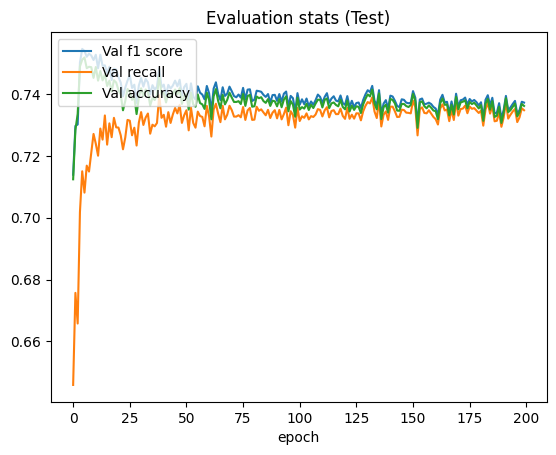

In [18]:
pyplot.plot(history.history["val_f1_m"],  label="Val f1 score")

pyplot.plot(history.history["val_recall_m"], label="Val recall")
pyplot.plot(history.history['val_acc'] , label="Val accuracy")
pyplot.xlabel("epoch")

pyplot.title('Evaluation stats (Test)')
pyplot.legend(loc="upper left")
pyplot.show()

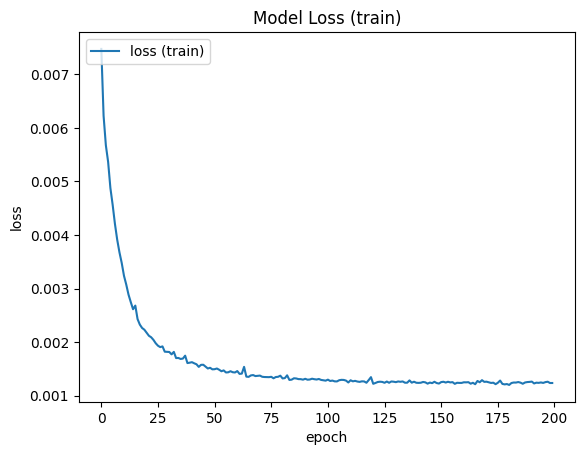

In [19]:
# plot metrics
import matplotlib.pyplot as pyplot

pyplot.plot(history.history["loss"],  label="loss (train)")
# pyplot.plot(history.history["val_loss"],  label="loss (test)")
pyplot.xlabel("epoch")
pyplot.ylabel("loss")

pyplot.title('Model Loss (train)')
pyplot.legend(loc="upper left")
pyplot.show()

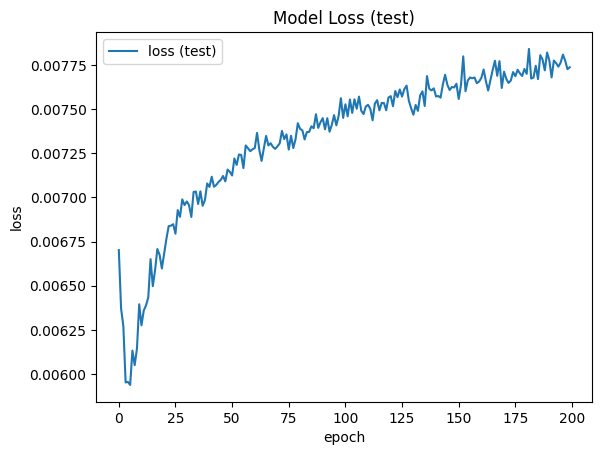

In [20]:
# plot metrics
import matplotlib.pyplot as pyplot

pyplot.plot(history.history["val_loss"],  label="loss (test)")
pyplot.xlabel("epoch")
pyplot.ylabel("loss")

pyplot.title('Model Loss (test)')
pyplot.legend(loc="upper left")
pyplot.show()

In [22]:
# serialize model to JSON
model_json = m.to_json()
with open("proposed_hybrid_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("proposed_hybrid_model.h5")
print("Saved model to disk")

Saved model to disk


In [47]:
from gensim.models.keyedvectors import KeyedVectors

print("*****Loading pre-trained GloVe model for Nepali*******")
# Load the pre-trained GloVe model for Nepali
wv = KeyedVectors.load_word2vec_format('processed.glove', binary=False)
print("*****Completed*******")


*****Loading pre-trained GloVe model for Nepali*******
*****Completed*******


In [115]:
# finally, vectorize the text samples into a 2D integer tensor

kinmelNews = "बीमा समितिले चार बीमा कम्पनीलाई अनलाइनमार्फत बीमा सेवा संचालन गर्न निर्देशन दिएको छ। समितिले नेस्नल लाईफ इन्सुरेन्स, युनियन लाइफ इन्सुरेन्स, रिलायबल लाइफ इन्सुरेन्स र सुर्य लाइफ इन्सुरेन्सलाई अनलाइन प्रणालीबाट बीमा लेख जारी गर्न तथा नवीकरण अनलाईन प्रणालीबाट गर्न निर्देशन दिएको हो। वैदेशिक रोजगारमा जाँदा बीमा एजेन्टहरुले किर्ते बीमा कागजात बनाएको तथा समयमै बीमा रकम भुक्तानी नभएको गुनासो गरेपछि बीमा समितिले चार कम्पनीलाई मात्र अनलाइनमार्फत बीमा अनुमति दिएको थियो।बीमा समितिले २०७५ माघदेखि नै यी कम्पनीलाई वैदेशिक रोजगारमा जानेको बीमा गर्ने अनुमति दिएको थियो। त्यसो त १९ जीवन बीमा कम्पनीमध्ये १४ कम्पनीहरु अहिले वैदेशिक रोजगार विभागमा दर्ता छन्। तर, बीमा समितिले भने ४ कम्पनीलाई मात्र कारोबारको अनुमति दिएको छ। ४ कम्पनीले बीमा कारोबारको अनुमति पाए पनि सबै जीवन बीमा कम्पनीले त्यसमा हिस्सेदारी हुनेगरी बीमा समितिले पुल बनाएको थियो। सो पुल बनाउँदा बीमा कारोबारबाट भएको नाफा वा घाटा १९ जीवन बीमा कम्पनीलाई नै बाँडिने बताइएको छ। नाफा भए सबै जीवन बीमा कम्पनीले हिस्सा पाउनेछन्। घाटा भए सबैले त्यसको क्षतिपूर्ति ब्यहोर्नुपर्ने छ। पछिल्लो समय वैदेशिक रोजगार विभागले वैदेशिक रोजगारको काम अनलाइनमार्फत गरिरहेको छ। त्यसैले बीमाको कारोबार पनि अनलाइनबाट गर्न बीमा समितिलाई विभागले भनेको थियो। सोहीअनुसार बीमा समितिले बीमा कम्पनीलाई अनलाइन कारोबार गर्न निर्देशन दिदैं पत्र पठाएको हो।"
reviews = [kinmelNews,
            newsTexts[30],
            newsTexts[1230],
            newsTexts[30233],
            newsTexts[55000],
          ]

tokenizer1 = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer1.fit_on_texts(reviews)
sequences1 = tokenizer.texts_to_sequences(reviews)
word_index1 = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index1))

testData = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', testData.shape)


Found 899236 unique tokens.
Shape of data tensor: (5, 1000)


In [121]:


def print_prediction(review, model):
    print("*****EVALUATE REVIEW*******")
    y_pred = model.predict(testData)
    # Find the index of the highest probability for each sample
    predicted_categories = y_pred.argmax(axis=1)
    for each_review, each_y_pred in zip(reviews, predicted_categories):
        print("News Text:\n{0}: Category is -> {1}".format(each_review, get_key(each_y_pred, labels_index)))
        print("\n")

def get_key(value, my_dict):
    for key, val in my_dict.items():
        if val == value:
            return key
    return None
print_prediction(review, m)

*****EVALUATE REVIEW*******
1/1 [==============================] - 0s 68ms/step
News Text:
बीमा समितिले चार बीमा कम्पनीलाई अनलाइनमार्फत बीमा सेवा संचालन गर्न निर्देशन दिएको छ। समितिले नेस्नल लाईफ इन्सुरेन्स, युनियन लाइफ इन्सुरेन्स, रिलायबल लाइफ इन्सुरेन्स र सुर्य लाइफ इन्सुरेन्सलाई अनलाइन प्रणालीबाट बीमा लेख जारी गर्न तथा नवीकरण अनलाईन प्रणालीबाट गर्न निर्देशन दिएको हो। वैदेशिक रोजगारमा जाँदा बीमा एजेन्टहरुले किर्ते बीमा कागजात बनाएको तथा समयमै बीमा रकम भुक्तानी नभएको गुनासो गरेपछि बीमा समितिले चार कम्पनीलाई मात्र अनलाइनमार्फत बीमा अनुमति दिएको थियो।बीमा समितिले २०७५ माघदेखि नै यी कम्पनीलाई वैदेशिक रोजगारमा जानेको बीमा गर्ने अनुमति दिएको थियो। त्यसो त १९ जीवन बीमा कम्पनीमध्ये १४ कम्पनीहरु अहिले वैदेशिक रोजगार विभागमा दर्ता छन्। तर, बीमा समितिले भने ४ कम्पनीलाई मात्र कारोबारको अनुमति दिएको छ। ४ कम्पनीले बीमा कारोबारको अनुमति पाए पनि सबै जीवन बीमा कम्पनीले त्यसमा हिस्सेदारी हुनेगरी बीमा समितिले पुल बनाएको थियो। सो पुल बनाउँदा बीमा कारोबारबाट भएको नाफा वा घाटा १९ जीवन बीमा कम्पनीलाई नै बा

In [23]:
# load json and create model
# from keras.models import model_from_json 
from tensorflow.keras.models import Sequential, model_from_json
from keras_self_attention import SeqSelfAttention


json_file = open('proposed_hybrid_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={'SeqSelfAttention': SeqSelfAttention})
# load weights into new model
loaded_model.load_weights("proposed_hybrid_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
score = loaded_model.evaluate(x_val, y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 73.61%
